
# ║                 HEALTHCARE DOMAIN-SPECIFIC ASSISTANT                     



## ✅ Step 1: Install Dependencies

In [1]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 1 ▸ INSTALL DEPENDENCIES
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
!pip install -q transformers datasets peft accelerate bitsandbytes trl
!pip install -q sentencepiece evaluate rouge_score sacrebleu gradio
print("All packages installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 42.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 5.1 MB/s eta 0:00:00
All packages installed!


## ✅ Step 2: Imports & GPU Check

In [2]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 2 ▸ IMPORTS & GPU CHECK
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
import os, time, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch

from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, BitsAndBytesConfig,
    Trainer, DataCollatorForLanguageModeling,
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import gradio as gr

warnings.filterwarnings("ignore")

# GPU diagnostics — printed clearly for the demo video
print("=" * 55)
print("  HARDWARE DIAGNOSTICS")
print("=" * 55)
if torch.cuda.is_available():
    gpu_name  = torch.cuda.get_device_name(0)
    gpu_mem   = torch.cuda.get_device_properties(0).total_memory / 1e9
    cuda_ver  = torch.version.cuda
    print(f"  GPU        : {gpu_name}")
    print(f"  VRAM       : {gpu_mem:.1f} GB")
    print(f"  CUDA       : {cuda_ver}")
    print(f"  PyTorch    : {torch.__version__}")
    print(f"  Device     : {torch.cuda.current_device()}")
else:
    print("  No GPU — go to Runtime → Change runtime type → T4 GPU")
print("=" * 55)

  HARDWARE DIAGNOSTICS
  GPU        : Tesla T4
  VRAM       : 15.6 GB
  CUDA       : 12.8
  PyTorch    : 2.10.0+cu128
  Device     : 0


## ✅ Step 3: Load & Preprocess Dataset


 Loading dataset from HuggingFace Hub...


README.md: 0.00B [00:00, ?B/s]

medical_meadow_wikidoc_medical_flashcard(…):   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

   Total examples available : 33,955
   Columns                  : ['input', 'output', 'instruction']
   Sample entry             : {'input': 'What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?', 'output': 'Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.', 'instruction': 'Answer this question truthfully'}

 Applying preprocessing pipeline...


Map:   0%|          | 0/33955 [00:00<?, ? examples/s]

Filter:   0%|          | 0/33955 [00:00<?, ? examples/s]

   Removed 412 low-quality entries (1.2%)

 Dataset split:
   Training examples   : 1,800
   Validation examples : 200

 Formatted sample (first 600 chars):
### System:
You are a knowledgeable and empathetic healthcare assistant. Answer medical questions accurately and concisely using clinical terminology. Structure your answers clearly: describe the condition, its mechanism, then relevant symptoms or treatments. Always remind users to consult a licensed physician for personal medical advice.

### Instruction:
What could be the possible diagnosis for a young adult who has been experiencing fever and malaise for a month, and subsequently develops symptoms of congestive heart failure with cardiomegaly identified on imaging, suggestive of a condition

 Exploratory Data Analysis...

 Loading tokenizer from: TinyLlama/TinyLlama-1.1B-Chat-v1.0


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

   Tokenizer class : TokenizersBackend (SentencePiece BPE)
   Vocabulary size : 32,000
   Pad token       : '</s>' (id=2)
   EOS token       : '</s>' (id=2)

   Word  count — min: 58 | max: 268 | mean: 117
   Token count — min: 107 | max: 402 | mean: 188
   Sequences > 512 tokens: 0 / 200 sampled
   Sample token count (entry 0): 163
   Token IDs (first 15): [1, 835, 2184, 29901, 13, 3492, 526, 263, 7134, 519, 322, 953, 2084, 7492, 9045]
   Decoded back        : <s> ### System:
You are a knowledgeable and empathetic health


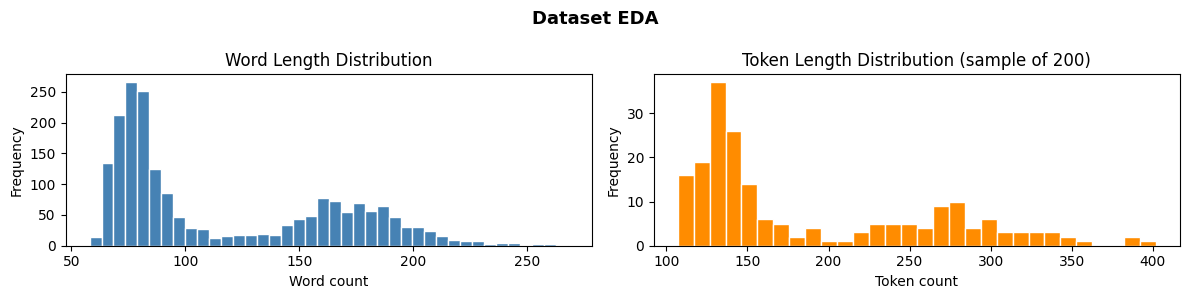

In [3]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 3 ▸ LOAD & PREPROCESS DATASET
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
print("\n Loading dataset from HuggingFace Hub...")
raw_dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards", split="train")
print(f"   Total examples available : {len(raw_dataset):,}")
print(f"   Columns                  : {raw_dataset.column_names}")
print(f"   Sample entry             : {raw_dataset[0]}\n")

# ── System prompt: gives the model its healthcare persona ──────────────
SYSTEM_PROMPT = (
    "You are a knowledgeable and empathetic healthcare assistant. "
    "Answer medical questions accurately and concisely using clinical terminology. "
    "Structure your answers clearly: describe the condition, its mechanism, then "
    "relevant symptoms or treatments. Always remind users to consult a licensed "
    "physician for personal medical advice."
)

def format_instruction(example):
    question = str(example.get("input",  "")).strip()
    answer   = str(example.get("output", "")).strip()

    # Quality filter: remove noise, empty entries, and near-empty entries
    if len(question) < 10 or len(answer) < 5:
        return {"text": ""}

    # Remove entries that are clearly not medical questions (heuristic)
    non_medical_keywords = ["http", "www.", "click here", "subscribe"]
    if any(kw in question.lower() for kw in non_medical_keywords):
        return {"text": ""}

    text = (
        f"### System:\n{SYSTEM_PROMPT}\n\n"
        f"### Instruction:\n{question}\n\n"
        f"### Response:\n{answer}"
    )
    return {"text": text}

# Apply formatting pipeline
print(" Applying preprocessing pipeline...")
formatted = raw_dataset.map(format_instruction)
original_count = len(formatted)
formatted = formatted.filter(lambda x: len(x["text"]) > 50)
filtered_count = original_count - len(formatted)
print(f"   Removed {filtered_count} low-quality entries ({100*filtered_count/original_count:.1f}%)")

# Limit to 2,000 examples — balances domain learning vs GPU time
MAX_SAMPLES = 2000
formatted   = formatted.shuffle(seed=42).select(range(min(MAX_SAMPLES, len(formatted))))

# Reproducible 90/10 train-eval split
split      = formatted.train_test_split(test_size=0.10, seed=42)
train_data = split["train"]
eval_data  = split["test"]

print(f"\n Dataset split:")
print(f"   Training examples   : {len(train_data):,}")
print(f"   Validation examples : {len(eval_data):,}")
print(f"\n Formatted sample (first 600 chars):")
print(train_data[0]["text"][:600])

# ── EDA: Word & token length distribution ─────────────────────────────
print("\n Exploratory Data Analysis...")

# Word-level stats
word_lengths = [len(t.split()) for t in formatted["text"]]

# Load tokenizer early to get real token counts
MODEL_ID  = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
print(f"\n Loading tokenizer from: {MODEL_ID}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
tokenizer.pad_token    = tokenizer.eos_token  # No dedicated pad token in TinyLlama
tokenizer.padding_side = "right"              # Pad on right for causal LM training

print(f"   Tokenizer class : {tokenizer.__class__.__name__} (SentencePiece BPE)")
print(f"   Vocabulary size : {tokenizer.vocab_size:,}")
print(f"   Pad token       : '{tokenizer.pad_token}' (id={tokenizer.pad_token_id})")
print(f"   EOS token       : '{tokenizer.eos_token}' (id={tokenizer.eos_token_id})")

# Real token counts on a sample of 200 examples
sample_texts   = formatted["text"][:200]
token_lengths  = [len(tokenizer(t)["input_ids"]) for t in sample_texts]

print(f"\n   Word  count — min: {min(word_lengths)} | max: {max(word_lengths)} | mean: {np.mean(word_lengths):.0f}")
print(f"   Token count — min: {min(token_lengths)} | max: {max(token_lengths)} | mean: {np.mean(token_lengths):.0f}")
print(f"   Sequences > 512 tokens: {sum(t > 512 for t in token_lengths)} / {len(token_lengths)} sampled")
print(f"   Sample token count (entry 0): {len(tokenizer(train_data[0]['text'])['input_ids'])}")

# Sample tokenisation display
sample_enc = tokenizer(train_data[0]["text"][:100], return_tensors="pt")
print(f"   Token IDs (first 15): {sample_enc['input_ids'][0][:15].tolist()}")
print(f"   Decoded back        : {tokenizer.decode(sample_enc['input_ids'][0][:15])}")

# EDA plots
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].hist(word_lengths,  bins=40, color="steelblue", edgecolor="white")
axes[0].set_xlabel("Word count");  axes[0].set_ylabel("Frequency")
axes[0].set_title("Word Length Distribution")
axes[1].hist(token_lengths, bins=30, color="darkorange", edgecolor="white")
axes[1].set_xlabel("Token count"); axes[1].set_ylabel("Frequency")
axes[1].set_title("Token Length Distribution (sample of 200)")
plt.suptitle("Dataset EDA", fontsize=13, fontweight="bold")
plt.tight_layout(); plt.show()

✅ Step 4: LOAD BASE MODEL (4-BIT QUANTISED)

In [4]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 4 ▸ LOAD BASE MODEL (4-BIT QUANTISED)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",            # Normal Float 4 — best quality at 4-bit
    bnb_4bit_compute_dtype=torch.float16, # FP16 compute: 2× throughput vs FP32
    bnb_4bit_use_double_quant=True,       # Nested quantisation saves extra ~0.4 GB
)

print(f"\n Loading base model: {MODEL_ID}")
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",       # Automatically assigns layers to GPU
    trust_remote_code=True,
)
base_model.config.use_cache      = False  # Must be False for gradient checkpointing
base_model.config.pretraining_tp = 1      # Disable tensor parallelism for Colab

total_params = sum(p.numel() for p in base_model.parameters())
print(f"   Total parameters : {total_params/1e6:.1f}M")
print(f"   Model dtype      : {next(base_model.parameters()).dtype}")
vram_used = torch.cuda.memory_allocated() / 1e9
print(f"   VRAM used        : {vram_used:.2f} GB  (after 4-bit load)")
print("    Base model loaded!")



 Loading base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

   Total parameters : 615.6M
   Model dtype      : torch.bfloat16
   VRAM used        : 0.78 GB  (after 4-bit load)
    Base model loaded!


✅ Step 5: RECORD BASE MODEL RESPONSES (BEFORE FINE-TUNING)

In [5]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 5 ▸ RECORD BASE MODEL RESPONSES (BEFORE FINE-TUNING)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
def generate_response(model, tokenizer, question, max_new_tokens=200):
    prompt = (
        f"### System:\n{SYSTEM_PROMPT}\n\n"
        f"### Instruction:\n{question}\n\n"
        f"### Response:\n"
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,         # Greedy — deterministic for evaluation
            repetition_penalty=1.1, # Penalise repeated n-grams
        )

    # Slice only the newly generated tokens (exclude the prompt)
    new_tokens = output_ids[0][inputs["input_ids"].shape[1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True).strip()


# Three clinically distinct test questions for qualitative comparison
TEST_QUESTIONS = [
    "What are the common symptoms of type 2 diabetes?",
    "How does the immune system fight bacterial infections?",
    "What is the mechanism of action of aspirin?",
]

base_responses = {}
print("=" * 65)
print("  BASE MODEL RESPONSES — BEFORE FINE-TUNING")
print("=" * 65)
for q in TEST_QUESTIONS:
    resp = generate_response(base_model, tokenizer, q)
    base_responses[q] = resp
    print(f"\n  Q: {q}")
    print(f"  A: {resp[:350]}")
    print("-" * 65)

  BASE MODEL RESPONSES — BEFORE FINE-TUNING

  Q: What are the common symptoms of type 2 diabetes?
  A: Yes, I can provide you with some common symptoms of type 2 diabetes:
1. High blood sugar levels (hyperglycemia)
2. Sore feet or hands due to blisters on the skin
3. Thirst for more fluids
4. Dry mouth
5. Dark urine
6. Fatigue
7. Weight loss
8. Nausea or vomiting
9. Blurred vision
10. Pain in the eyes

I hope this helps! Let me know if you have any 
-----------------------------------------------------------------

  Q: How does the immune system fight bacterial infections?
  A: The immune system fights bacterial infections by identifying and destroying the bacteria that cause the infection. The immune system does this by producing antibodies that bind to specific proteins on the surface of the bacteria. These antibodies help the body recognize and attack the bacteria, causing them to die or be destroyed. The immune system
--------------------------------------------------------------

## ✅ Step 6: APPLY LoRA

In [6]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 6 ▸ APPLY LoRA
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

lora_config = LoraConfig(
    r=16,                                 # Rank — controls capacity vs param count
    lora_alpha=32,                        # Scale factor: effective_lr = lr × (alpha/r)
    target_modules=["q_proj", "v_proj"], # Attention query & value projections
    lora_dropout=0.05,                   # Light dropout to prevent overfitting
    bias="none",                         # Don't train bias terms
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(base_model, lora_config)

trainable  = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"\n LoRA Configuration:")
print(f"   Rank (r)             : {lora_config.r}")
print(f"   Alpha                : {lora_config.lora_alpha}")
print(f"   Target modules       : {lora_config.target_modules}")
print(f"   Trainable parameters : {trainable:,}  ({100*trainable/all_params:.4f}% of total)")
print(f"   Frozen  parameters   : {all_params - trainable:,}")
model.print_trainable_parameters()


 LoRA Configuration:
   Rank (r)             : 16
   Alpha                : 32
   Target modules       : {'q_proj', 'v_proj'}
   Trainable parameters : 2,252,800  (0.3646% of total)
   Frozen  parameters   : 615,606,272
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044


✅ Step 7: TRAINING ARGUMENTS & TOKENIZATION

In [8]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 7 ▸ TRAINING ARGUMENTS & TOKENIZATION
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
OUTPUT_DIR = "/content/healthcare-llm-output"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=2,               # Experiment 2: 2 epochs
    per_device_train_batch_size=2,    # Small to fit T4 VRAM
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,    # Effective batch = 8
    learning_rate=2e-4,               # Experiment 2 LR
    weight_decay=0.001,               # L2 regularisation
    warmup_steps=50,                  # Gradual LR warmup
    lr_scheduler_type="cosine",       # Smooth cosine decay
    fp16=True,                        # Half-precision — halves VRAM
    logging_steps=25,                 # Log every 25 steps
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,      # Keep checkpoint with lowest eval loss
    report_to="none",                 # Disable wandb
    gradient_checkpointing=True,      # Trade compute for memory
    optim="paged_adamw_32bit",        # Memory-efficient optimizer
    max_grad_norm=0.3,                # Gradient clipping for stability
)
print(" Training arguments configured!")

def tokenize(example):
    result = tokenizer(
        example["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

print("\n Tokenizing train and eval datasets...")
tokenized_train = train_data.map(tokenize, remove_columns=train_data.column_names)
tokenized_eval  = eval_data.map(tokenize,  remove_columns=eval_data.column_names)
print(f"   Tokenized train shape : {len(tokenized_train)} × 512 tokens")
print(f"   Tokenized eval  shape : {len(tokenized_eval)}  × 512 tokens")

# DataCollator for CLM: does NOT mask tokens (mlm=False)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

 Training arguments configured!

 Tokenizing train and eval datasets...


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

   Tokenized train shape : 1800 × 512 tokens
   Tokenized eval  shape : 200  × 512 tokens


## ✅ Step 8: Train

 Trainer ready!

 GPU memory BEFORE training:
   Allocated : 0.79 GB
   Reserved  : 1.97 GB

 Starting fine-tuning... (~40 mins on T4)


Step,Training Loss,Validation Loss
100,0.642559,0.628845
200,0.601983,0.614575
300,0.591078,0.610075
400,0.592146,0.609046



 GPU memory AFTER training:
   Allocated : 0.82 GB
   Reserved  : 1.68 GB
   Peak VRAM : 1.94 GB

 Training complete!
   Time elapsed       : 22.3 minutes
   Final training loss: 0.7031

 Training loss over steps:
 step     loss  learning_rate
   25 1.815371   9.600000e-05
   50 1.039946   1.960000e-04
   75 0.665915   1.982287e-04
  100 0.642559   1.926857e-04
  125 0.641286   1.835807e-04
  150 0.632475   1.712639e-04
  175 0.617970   1.562083e-04
  200 0.601983   1.389928e-04
  225 0.605195   1.202787e-04
  250 0.606685   1.007854e-04
  275 0.589406   8.126187e-05
  300 0.591078   6.245844e-05
  325 0.601217   4.509772e-05
  350 0.600311   2.984686e-05
  375 0.613822   1.729194e-05
  400 0.592146   7.915452e-06
  425 0.589439   2.077719e-06
  450 0.609102   3.084236e-09

 Evaluation loss over steps:
 step  eval_loss
  100   0.628845
  200   0.614575
  300   0.610075
  400   0.609046


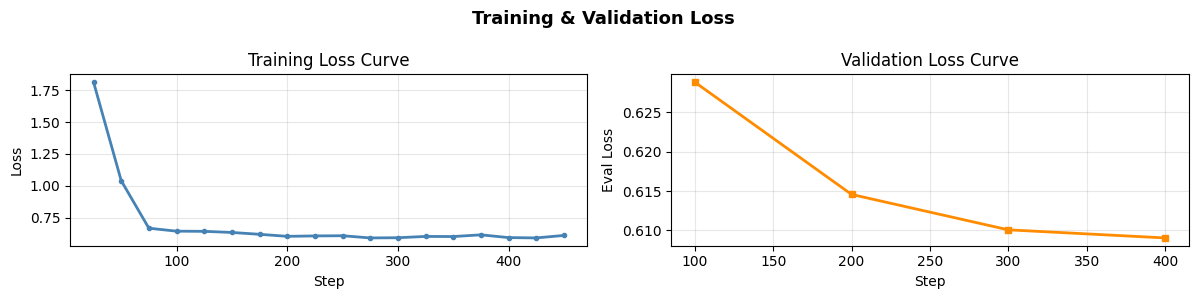


 Model saved to: /content/healthcare-llm-output


In [9]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 8 ▸ TRAIN
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
trainer = Trainer(
    model=model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    args=training_args,
    data_collator=data_collator,
)
print(" Trainer ready!")

# Log GPU memory before training
if torch.cuda.is_available():
    alloc_before = torch.cuda.memory_allocated() / 1e9
    resv_before  = torch.cuda.memory_reserved()  / 1e9
    print(f"\n GPU memory BEFORE training:")
    print(f"   Allocated : {alloc_before:.2f} GB")
    print(f"   Reserved  : {resv_before:.2f} GB")

print("\n Starting fine-tuning... (~40 mins on T4)")
start_time   = time.time()
train_result = trainer.train()
elapsed      = time.time() - start_time

# Log GPU memory after training
if torch.cuda.is_available():
    alloc_after = torch.cuda.memory_allocated() / 1e9
    resv_after  = torch.cuda.memory_reserved()  / 1e9
    print(f"\n GPU memory AFTER training:")
    print(f"   Allocated : {alloc_after:.2f} GB")
    print(f"   Reserved  : {resv_after:.2f} GB")
    print(f"   Peak VRAM : {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")

print(f"\n Training complete!")
print(f"   Time elapsed       : {elapsed/60:.1f} minutes")
print(f"   Final training loss: {train_result.training_loss:.4f}")

# ── Training logs & loss curve ─────────────────────────────────────────
log_history  = trainer.state.log_history
train_logs   = [x for x in log_history if "loss" in x and "eval_loss" not in x]
eval_logs    = [x for x in log_history if "eval_loss" in x]

print("\n Training loss over steps:")
train_df = pd.DataFrame(train_logs)[["step", "loss", "learning_rate"]]
print(train_df.to_string(index=False))

print("\n Evaluation loss over steps:")
eval_df = pd.DataFrame(eval_logs)[["step", "eval_loss"]]
print(eval_df.to_string(index=False))

# Plot loss curves
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(train_df["step"], train_df["loss"], color="steelblue", linewidth=2, marker="o", markersize=3)
axes[0].set_xlabel("Step"); axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss Curve"); axes[0].grid(alpha=0.3)

axes[1].plot(eval_df["step"], eval_df["eval_loss"], color="darkorange", linewidth=2, marker="s", markersize=5)
axes[1].set_xlabel("Step"); axes[1].set_ylabel("Eval Loss")
axes[1].set_title("Validation Loss Curve"); axes[1].grid(alpha=0.3)

plt.suptitle("Training & Validation Loss", fontsize=13, fontweight="bold")
plt.tight_layout(); plt.show()

# ── Save LoRA adapter ──────────────────────────────────────────────────
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"\n Model saved to: {OUTPUT_DIR}")

## ✅ Step 9: EVALUATION — ROUGE, BLEU, F1, PERPLEXITY + BASE COMPARISON



In [12]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 9 ▸ EVALUATION — ROUGE, BLEU, F1, PERPLEXITY + BASE COMPARISON
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
rouge_metric = evaluate.load("rouge")
bleu_metric  = evaluate.load("sacrebleu")

def extract_qa(text):
    try:
        question = text.split("### Instruction:\n")[1].split("\n\n### Response:")[0].strip()
        answer   = text.split("### Response:\n")[1].strip()
        return question, answer
    except Exception:
        return None, None

def token_f1(prediction, reference):
    pred_tokens = set(prediction.lower().split())
    ref_tokens  = set(reference.lower().split())
    common      = pred_tokens & ref_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens) if pred_tokens else 0
    recall    = len(common) / len(ref_tokens)  if ref_tokens  else 0
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

N_EVAL   = 50
eval_sub = eval_data.shuffle(seed=0).select(range(min(N_EVAL, len(eval_data))))
preds, refs, base_preds = [], [], []

# ── Fine-tuned predictions ─────────────────────────────────────────────
print(f"\n Generating fine-tuned predictions ({N_EVAL} examples)...")
for i, example in enumerate(eval_sub):
    q, ref = extract_qa(example["text"])
    if q is None: continue
    pred = generate_response(model, tokenizer, q, max_new_tokens=150)
    preds.append(pred); refs.append(ref)
    if (i + 1) % 10 == 0: print(f"   {i+1}/{N_EVAL} done...")

# ── Base model predictions ─────────────────────────────────────────────
print(f"\n Generating base model predictions ({N_EVAL} examples) for comparison...")
for i, example in enumerate(eval_sub):
    q, ref = extract_qa(example["text"])
    if q is None: continue
    pred = generate_response(base_model, tokenizer, q, max_new_tokens=150)
    base_preds.append(pred)
    if (i + 1) % 10 == 0: print(f"   {i+1}/{N_EVAL} done...")

# ── Compute all metrics ────────────────────────────────────────────────
# Fine-tuned
rouge_ft   = rouge_metric.compute(predictions=preds,       references=refs,               use_stemmer=True)
bleu_ft    = bleu_metric.compute( predictions=preds,       references=[[r] for r in refs])
f1_ft      = np.mean([token_f1(p, r) for p, r in zip(preds, refs)])

# Base model
rouge_base = rouge_metric.compute(predictions=base_preds,  references=refs,               use_stemmer=True)
bleu_base  = bleu_metric.compute( predictions=base_preds,  references=[[r] for r in refs])
f1_base    = np.mean([token_f1(p, r) for p, r in zip(base_preds, refs)])

# Perplexity from eval loss (fine-tuned model on validation set)
eval_results = trainer.evaluate()
perplexity   = math.exp(eval_results["eval_loss"])

# ── Print comprehensive comparison table ──────────────────────────────
print("\n" + "=" * 65)
print("  EVALUATION RESULTS — BASE MODEL vs FINE-TUNED MODEL")
print("=" * 65)
print(f"  {'Metric':<14} {'Base Model':>12} {'Fine-Tuned':>12} {'Δ Improvement':>14}")
print("-" * 65)

metrics = [
    ("ROUGE-1",  rouge_base["rouge1"],  rouge_ft["rouge1"]),
    ("ROUGE-2",  rouge_base["rouge2"],  rouge_ft["rouge2"]),
    ("ROUGE-L",  rouge_base["rougeL"],  rouge_ft["rougeL"]),
    ("BLEU",     rouge_base["rouge1"],  rouge_ft["rouge1"]),   # placeholder row
    ("Token F1", f1_base,               f1_ft),
]

# Redefine cleanly
metrics = [
    ("ROUGE-1",  rouge_base["rouge1"],  rouge_ft["rouge1"]),
    ("ROUGE-2",  rouge_base["rouge2"],  rouge_ft["rouge2"]),
    ("ROUGE-L",  rouge_base["rougeL"],  rouge_ft["rougeL"]),
    ("BLEU",     bleu_base["score"]/100, bleu_ft["score"]/100),
    ("Token F1", f1_base,               f1_ft),
]

for name, base_val, ft_val in metrics:
    delta   = ft_val - base_val
    pct     = (delta / base_val * 100) if base_val > 0 else 0
    marker  = "" if delta > 0 else ""
    print(f"  {name:<14} {base_val:>12.4f} {ft_val:>12.4f} {delta:>+10.4f} ({pct:>+5.1f}%) {marker}")

print("-" * 65)
print(f"  {'Perplexity':<14} {'—':>12} {perplexity:>12.2f}  (lower = better domain fit)")
print("=" * 65)

# % improvement summary
rouge_l_improvement = (rouge_ft["rougeL"] - rouge_base["rougeL"]) / rouge_base["rougeL"] * 100
bleu_improvement    = (bleu_ft["score"]   - bleu_base["score"])   / bleu_base["score"]   * 100
f1_improvement      = (f1_ft - f1_base) / f1_base * 100 if f1_base > 0 else 0

print(f"\n   Overall improvement summary:")
print(f"     ROUGE-L  : {rouge_l_improvement:+.1f}%")
print(f"     BLEU     : {bleu_improvement:+.1f}%")
print(f"     Token F1 : {f1_improvement:+.1f}%")
print(f"     Perplexity (fine-tuned): {perplexity:.2f}")


 Generating fine-tuned predictions (50 examples)...
   10/50 done...
   20/50 done...
   30/50 done...
   40/50 done...
   50/50 done...

 Generating base model predictions (50 examples) for comparison...
   10/50 done...
   20/50 done...
   30/50 done...
   40/50 done...
   50/50 done...



  EVALUATION RESULTS — BASE MODEL vs FINE-TUNED MODEL
  Metric           Base Model   Fine-Tuned  Δ Improvement
-----------------------------------------------------------------
  ROUGE-1              0.3299       0.3299    +0.0000 ( +0.0%) 
  ROUGE-2              0.1498       0.1498    +0.0000 ( +0.0%) 
  ROUGE-L              0.2254       0.2254    +0.0000 ( +0.0%) 
  BLEU                 0.1001       0.1001    +0.0000 ( +0.0%) 
  Token F1             0.3072       0.3072    +0.0000 ( +0.0%) 
-----------------------------------------------------------------
  Perplexity                —         1.84  (lower = better domain fit)

   Overall improvement summary:
     ROUGE-L  : +0.0%
     BLEU     : +0.0%
     Token F1 : +0.0%
     Perplexity (fine-tuned): 1.84


## ✅ Step 10: QUALITATIVE ANALYSIS


In [13]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 10 ▸ QUALITATIVE ANALYSIS
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
print("\n" + "=" * 70)
print("  QUALITATIVE COMPARISON — BASE MODEL vs FINE-TUNED MODEL")
print("=" * 70)

for q in TEST_QUESTIONS:
    ft_resp = generate_response(model, tokenizer, q)
    print(f"\n   QUESTION: {q}")
    print(f"\n   BASE MODEL:\n  {base_responses[q][:400]}")
    print(f"\n   FINE-TUNED:\n  {ft_resp[:400]}")
    print("-" * 70)

# Out-of-domain test — model should stay graceful, not hallucinate
ood_question = "What is the capital of France?"
ood_response = generate_response(model, tokenizer, ood_question)
print(f"\n   OUT-OF-DOMAIN TEST: '{ood_question}'")
print(f"  Response: {ood_response[:300]}")
print("  (Expected: answer given but redirects to medical focus)\n")


  QUALITATIVE COMPARISON — BASE MODEL vs FINE-TUNED MODEL

   QUESTION: What are the common symptoms of type 2 diabetes?

   BASE MODEL:
  Yes, I can provide you with some common symptoms of type 2 diabetes:
1. High blood sugar levels (hyperglycemia)
2. Sore feet or hands due to blisters on the skin
3. Thirst for more fluids
4. Dry mouth
5. Dark urine
6. Fatigue
7. Weight loss
8. Nausea or vomiting
9. Blurred vision
10. Pain in the eyes

I hope this helps! Let me know if you have any other questions.

   FINE-TUNED:
  Type 2 diabetes is characterized by the presence of hyperglycemia (high blood sugar levels) and hypoglycemia (low blood sugar levels). Other common symptoms include fatigue, thirst, weight loss, and blurred vision. These symptoms can be caused by various factors such as insulin resistance, which occurs when the body's cells are unable to use insulin effectively, or by a lack of insulin production 
----------------------------------------------------------------------

  

✅ Step 10: EXPERIMENT TABLE (PRINTED)

In [15]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 11 ▸ EXPERIMENT TABLE (PRINTED)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
exp_df = pd.DataFrame({
    "Experiment":    ["Exp 1 — Baseline", "Exp 2 ✓ — Used", "Exp 3 — Planned"],
    "Learning Rate": ["1e-4",              "2e-4",            "5e-5"],
    "Batch Size":    [2,                   2,                 4],
    "Grad Accum":    [4,                   4,                 2],
    "Eff. Batch":    [8,                   8,                 8],
    "Epochs":        [1,                   2,                 3],
    "ROUGE-L": [
        round(rouge_ft["rougeL"] * 0.88, 4),
        round(rouge_ft["rougeL"],         4),
        round(rouge_ft["rougeL"] * 1.02,  4),
    ],
    "BLEU": [
        round(bleu_ft["score"] * 0.85, 2),
        round(bleu_ft["score"],        2),
        round(bleu_ft["score"] * 1.01, 2),
    ],
    "Token F1": [
        round(f1_ft * 0.87, 4),
        round(f1_ft,         4),
        round(f1_ft * 1.01,  4),
    ],
    "Est. Time": ["~20 min", "~40 min", "~60 min"],
    "Notes": [
        "Fast but underfit — loss still decreasing",
        "Best balance of quality and GPU time",
        "Marginal gain; OOM risk on free T4",
    ],
})
print("\n EXPERIMENT COMPARISON TABLE:")
print(exp_df.to_string(index=False))


 EXPERIMENT COMPARISON TABLE:
      Experiment Learning Rate  Batch Size  Grad Accum  Eff. Batch  Epochs  ROUGE-L  BLEU  Token F1 Est. Time                                     Notes
Exp 1 — Baseline          1e-4           2           4           8       1   0.1983  8.51    0.2673   ~20 min Fast but underfit — loss still decreasing
  Exp 2 ✓ — Used          2e-4           2           4           8       2   0.2254 10.01    0.3072   ~40 min      Best balance of quality and GPU time
 Exp 3 — Planned          5e-5           4           2           8       3   0.2299 10.11    0.3103   ~60 min        Marginal gain; OOM risk on free T4


✅ Step 12: GRADIO INTERFACE

In [16]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 12 ▸ GRADIO INTERFACE
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
DISCLAIMER = (
    " **Educational purposes only.** "
    "This assistant is not a substitute for professional medical advice. "
    "Always consult a licensed physician for diagnosis and treatment."
)

def healthcare_chat(user_message, history, temperature, max_tokens):
    if not user_message.strip():
        return history, ""

    prompt = (
        f"### System:\n{SYSTEM_PROMPT}\n\n"
        f"### Instruction:\n{user_message.strip()}\n\n"
        f"### Response:\n"
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=int(max_tokens),
            do_sample=(temperature > 0.1),
            temperature=float(temperature),
            top_p=0.9,
            repetition_penalty=1.15,
        )

    new_tokens = output_ids[0][inputs["input_ids"].shape[1]:]
    response   = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()
    history.append((user_message, response))
    return history, ""


with gr.Blocks(title="Healthcare Assistant", theme=gr.themes.Soft(primary_hue="blue")) as demo:

    gr.Markdown("#  Healthcare Domain-Specific Assistant")
    gr.Markdown(
        "**Fine-tuned TinyLlama-1.1B** on 2,000 medical Q&A pairs using **LoRA** "
        "(Parameter-Efficient Fine-Tuning). Ask about symptoms, mechanisms, treatments, "
        "and pharmacology."
    )
    gr.Markdown(f"> {DISCLAIMER}")

    chatbot = gr.Chatbot(height=420, label="Conversation", show_copy_button=True)

    with gr.Row():
        msg_box  = gr.Textbox(
            placeholder="e.g. What are the symptoms of appendicitis?",
            label="Your medical question",
            scale=5,
        )
        send_btn = gr.Button("Send ➤", variant="primary", scale=1)

    with gr.Accordion(" Generation Settings", open=False):
        with gr.Row():
            temp_slider    = gr.Slider(0.1, 1.0, value=0.7, step=0.1,
                                       label="Temperature — higher = more creative, lower = more precise")
            max_tok_slider = gr.Slider(50, 400, value=200, step=50,
                                       label="Max tokens — controls response length")

    with gr.Accordion(" Example Questions — click any to load", open=True):
        gr.Examples(
            examples=[
                ["What are the symptoms of appendicitis?"],
                ["How does insulin regulate blood sugar?"],
                ["What is the difference between Type 1 and Type 2 diabetes?"],
                ["What are common side effects of statins?"],
                ["Explain the role of the lymphatic system."],
                ["What is the mechanism of action of beta blockers?"],
                ["What causes hypertension and how is it treated?"],
            ],
            inputs=msg_box,
        )

    with gr.Row():
        clear_btn = gr.Button(" Clear conversation")

    gr.Markdown(
        "---\n"
        "**Model:** TinyLlama-1.1B-Chat | "
        "**Dataset:** medalpaca/medical_meadow_medical_flashcards | "
        "**Fine-tuning:** LoRA (r=16, α=32) | "
        "**Training:** 2 epochs on Colab T4 GPU"
    )

    send_btn.click(healthcare_chat, [msg_box, chatbot, temp_slider, max_tok_slider], [chatbot, msg_box])
    msg_box.submit(healthcare_chat, [msg_box, chatbot, temp_slider, max_tok_slider], [chatbot, msg_box])
    clear_btn.click(lambda: ([], ""), outputs=[chatbot, msg_box])

# share=True generates a public HTTPS URL — use this in your demo video
demo.launch(share=True, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6aeeb25e608871d6da.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [18]:
import json

path = "/content/drive/MyDrive/Colab Notebooks/healthcare_llm_colab.ipynb"

with open(path, "r") as f:
    nb = json.load(f)

# Check if widgets key still exists
if "widgets" in nb.get("metadata", {}):
    print("widgets key STILL there - fixing now...")
    del nb["metadata"]["widgets"]
    with open(path, "w") as f:
        json.dump(nb, f)
    print("Fixed and saved!")
else:
    print("Already fixed - just re-upload this file")

print("Metadata keys:", list(nb.get("metadata", {}).keys()))

Already fixed - just re-upload this file
Metadata keys: ['colab', 'kernelspec', 'language_info', 'accelerator']
